In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle as pkl
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

/home/akshayy/anaconda3/envs/flb_rnaseq/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
bbox1_counts_df = pd.read_csv("counts_table.csv")
bbox1_counts_df = bbox1_counts_df.drop('Unnamed: 0', axis=1)

In [3]:
bbox1_info_df = bbox1_counts_df[['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length']]
bbox1_counts_df = bbox1_counts_df.drop(['Chr', 'Start', 'End', 'Strand', 'Length'], axis=1)

In [4]:
bbox1_counts_df = bbox1_counts_df.rename(columns = {'bam_files.mda.mb.468_shbbox1_ctl_rep1.bam':'shbbox1_ctl_rep1',
                                 'bam_files.mda.mb.468_shbbox1_ctl_rep2.bam':'shbbox1_ctl_rep2',
                                 'bam_files.mda.mb.468_shbbox1_ctl_rep3.bam':'shbbox1_ctl_rep3',
                                 'bam_files.mda.mb.468_shbbox1_sh1_rep1.bam':'shbbox1_sh1_rep1',
                                 'bam_files.mda.mb.468_shbbox1_sh1_rep2.bam':'shbbox1_sh1_rep2',
                                 'bam_files.mda.mb.468_shbbox1_sh1_rep3.bam':'shbbox1_sh1_rep3',
                                 'bam_files.mda.mb.468_shbbox1_sh6_rep1.bam':'shbbox1_sh6_rep1',
                                 'bam_files.mda.mb.468_shbbox1_sh6_rep2.bam':'shbbox1_sh6_rep2',
                                 'bam_files.mda.mb.468_shbbox1_sh6_rep3.bam':'shbbox1_sh6_rep3'})

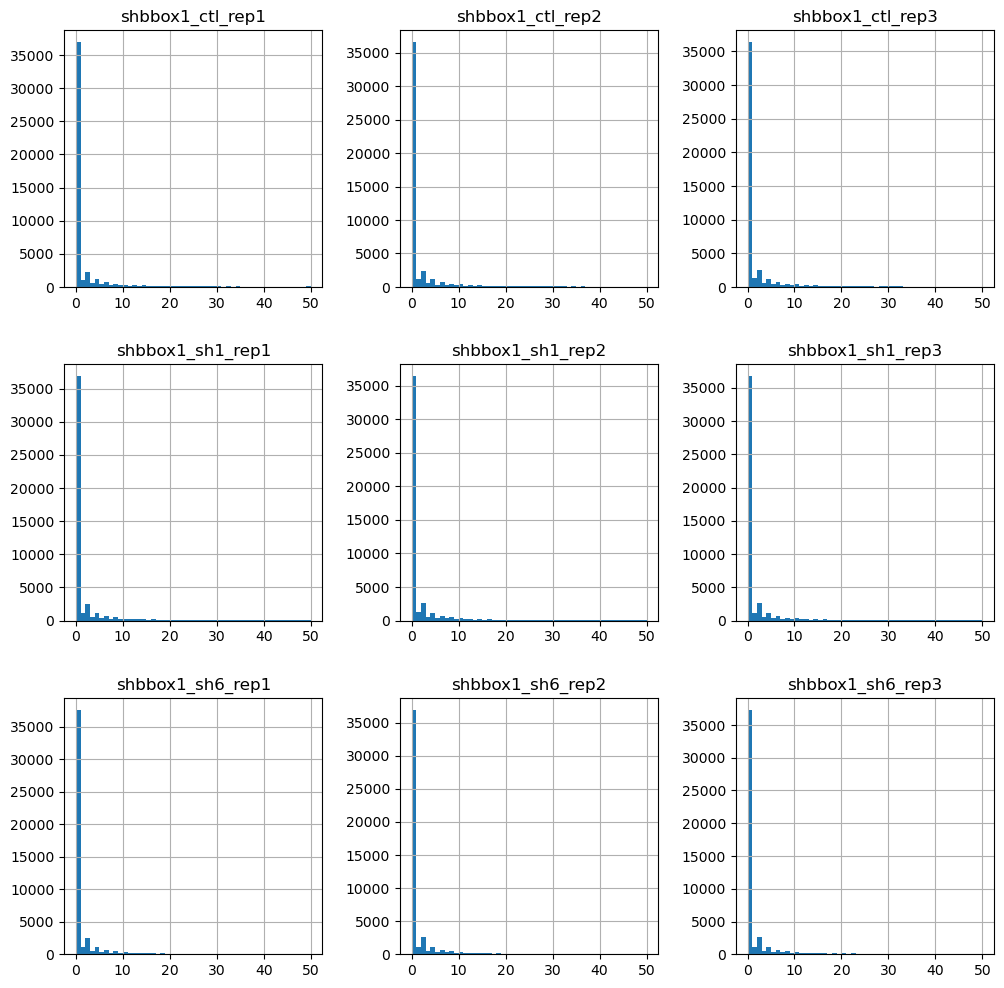

In [5]:
fig, axis = plt.subplots(3, 3, figsize=(12, 12))
bbox1_counts_df.iloc[:,1:].hist(ax=axis, bins = 50, range=(0, 50))
plt.show()

In [6]:
shbbox1_ctl_mean_var_df = pd.DataFrame()
shbbox1_ctl_mean_var_df = pd.concat([shbbox1_ctl_mean_var_df, bbox1_counts_df[['shbbox1_ctl_rep1','shbbox1_ctl_rep2','shbbox1_ctl_rep3']].mean(axis=1), bbox1_counts_df[['shbbox1_ctl_rep1','shbbox1_ctl_rep2','shbbox1_ctl_rep3']].var(axis=1)], axis=1)
shbbox1_ctl_mean_var_df.columns = ['mean', 'variance']

In [7]:
shbbox1_sh1_mean_var_df = pd.DataFrame()
shbbox1_sh1_mean_var_df = pd.concat([shbbox1_sh1_mean_var_df, bbox1_counts_df[['shbbox1_sh1_rep1','shbbox1_sh1_rep2','shbbox1_sh1_rep3']].mean(axis=1), bbox1_counts_df[['shbbox1_sh1_rep1','shbbox1_sh1_rep2','shbbox1_sh1_rep3']].var(axis=1)], axis=1)
shbbox1_sh1_mean_var_df.columns = ['mean', 'variance']

In [8]:
shbbox1_sh6_mean_var_df = pd.DataFrame()
shbbox1_sh6_mean_var_df = pd.concat([shbbox1_sh6_mean_var_df, bbox1_counts_df[['shbbox1_sh6_rep1','shbbox1_sh6_rep2','shbbox1_sh6_rep3']].mean(axis=1), bbox1_counts_df[['shbbox1_sh6_rep1','shbbox1_sh6_rep2','shbbox1_sh6_rep3']].var(axis=1)], axis=1)
shbbox1_sh6_mean_var_df.columns = ['mean', 'variance']

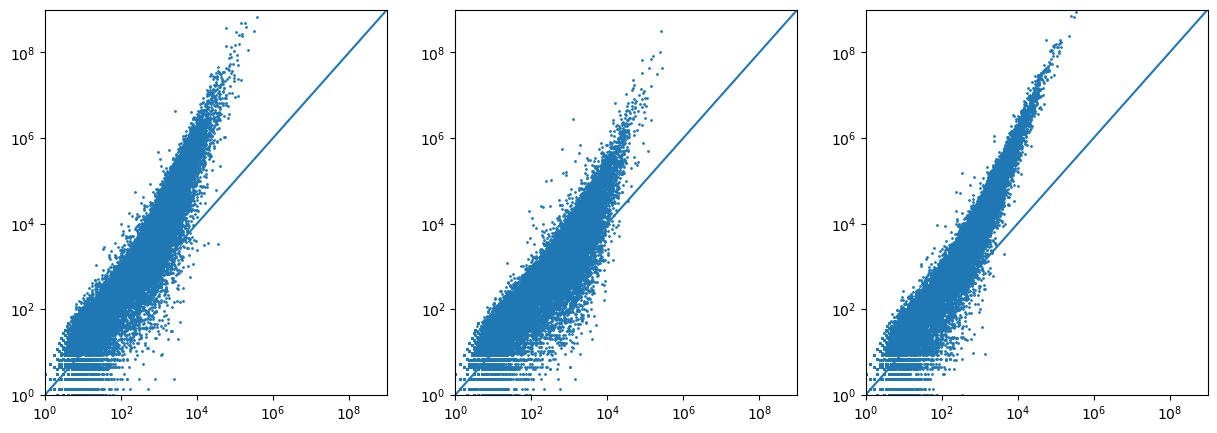

In [9]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    axis[i].set_xlim(1, 1e9)
    axis[i].set_ylim(1, 1e9)
    axis[i].set_xscale("log")
    axis[i].set_yscale("log")
    axis[i].plot([1, 1e9], [1, 1e9])
axis[0].scatter(shbbox1_ctl_mean_var_df['mean'], shbbox1_ctl_mean_var_df['variance'], s=1)
axis[1].scatter(shbbox1_sh1_mean_var_df['mean'], shbbox1_sh1_mean_var_df['variance'], s=1)
axis[2].scatter(shbbox1_sh6_mean_var_df['mean'], shbbox1_sh6_mean_var_df['variance'], s=1)
plt.show()



The per-sample count distribution is skewed towards lower counts suggesting that majority of genes have very low counts. The per-treatment Mean v/s Variance plots show that mean is not equal to variance (mean<variance) and genes with lower expression counts have higher variance. Together, these suggest that per-sample gene counts can be modeled using Negative Binomial (NB) distribution.



In [10]:
bbox1_counts_df = bbox1_counts_df.set_index('Geneid')
bbox1_counts_df = bbox1_counts_df.T

In [11]:
bbox1_metadata = pd.read_csv("metadata.csv")
bbox1_metadata = bbox1_metadata.set_index('sample')

In [12]:
selected_genes = bbox1_counts_df.columns[bbox1_counts_df.sum(axis=0) >= 10]

In [13]:
bbox1_counts_df_filtered = bbox1_counts_df[selected_genes]
bbox1_counts_df_filtered.head()

Geneid,ENSG00000160072,ENSG00000260179,ENSG00000225972,ENSG00000198744,ENSG00000225630,ENSG00000131584,ENSG00000169972,ENSG00000157911,ENSG00000269896,ENSG00000237973,...,ENSG00000210196,ENSG00000278704,ENSG00000276256,ENSG00000273748,ENSG00000277196,ENSG00000278817,ENSG00000278384,ENSG00000278066,ENSG00000276345,ENSG00000271254
shbbox1_ctl_rep1,433,2,22,124,2162,1696,706,363,48,1488,...,2635,7,188,6,181,259,58,4,19,920
shbbox1_ctl_rep2,392,1,22,98,2441,1622,640,354,50,1169,...,2754,16,217,8,148,99,26,4,98,734
shbbox1_ctl_rep3,474,7,20,45,2723,2018,1028,424,48,1341,...,1695,14,230,4,118,94,59,0,29,1070
shbbox1_sh1_rep1,610,8,21,82,2284,1711,921,437,125,2031,...,1269,13,157,14,57,73,40,0,37,804
shbbox1_sh1_rep2,613,10,23,66,2248,1931,890,438,161,1281,...,1326,8,205,11,26,86,45,0,48,898


In [14]:
bbox1_dds = DeseqDataSet(counts=bbox1_counts_df_filtered, metadata=bbox1_metadata, design_factors="condition", refit_cooks=True, n_cpus=2)

In [15]:
bbox1_dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 25.46 seconds.

Fitting dispersion trend curve...
... done in 12.03 seconds.

Fitting MAP dispersions...
... done in 26.45 seconds.

Fitting LFCs...
... done in 14.78 seconds.

Refitting 0 outliers.



In [16]:
OUTPUT_PATH = "."
with open(os.path.join(OUTPUT_PATH, "bbox1_dds.pkl"), "wb") as f:
        pkl.dump(bbox1_dds, f)

In [17]:
bbox1_stat_res_sh1 = DeseqStats(bbox1_dds, contrast=["condition", "sh1", "ctl"], n_cpus=2)
bbox1_stat_res_sh6 = DeseqStats(bbox1_dds, contrast=["condition", "sh6", "ctl"], n_cpus=2)

In [18]:
bbox1_stat_res_sh1.summary()

Running Wald tests...
... done in 4.58 seconds.



Log2 fold change & Wald test p-value: condition sh1 vs ctl


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
ENSG00000160072,537.363551,0.520866,0.102402,5.086502,3.647282e-07,0.000002
ENSG00000260179,7.165343,1.537548,0.854130,1.800133,7.183964e-02,0.146963
ENSG00000225972,19.476641,-0.042814,0.475585,-0.090023,9.282690e-01,0.957891
ENSG00000198744,67.762127,-0.339086,0.329861,-1.027966,3.039660e-01,0.456687
ENSG00000225630,2163.216791,-0.088167,0.073315,-1.202577,2.291400e-01,0.369327
...,...,...,...,...,...,...
ENSG00000278817,105.290655,-0.932806,0.565282,-1.650161,9.891002e-02,0.191426
ENSG00000278384,44.095179,-0.121885,0.346259,-0.352007,7.248329e-01,0.824136
ENSG00000278066,1.579824,-1.964279,2.100686,-0.935065,3.497546e-01,NaN


In [19]:
bbox1_stat_res_sh6.summary()

Running Wald tests...
... done in 4.60 seconds.



Log2 fold change & Wald test p-value: condition sh6 vs ctl


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
ENSG00000160072,537.363551,0.579137,0.102318,5.660197,1.511993e-08,7.866809e-08
ENSG00000260179,7.165343,1.594787,0.853496,1.868534,6.168774e-02,1.166379e-01
ENSG00000225972,19.476641,-0.131732,0.478936,-0.275051,7.832769e-01,8.570818e-01
ENSG00000198744,67.762127,-0.799461,0.336194,-2.377976,1.740794e-02,3.845426e-02
ENSG00000225630,2163.216791,-0.206820,0.073565,-2.811410,4.932487e-03,1.235191e-02
...,...,...,...,...,...,...
ENSG00000278817,105.290655,-0.622819,0.563894,-1.104496,2.693780e-01,3.923500e-01
ENSG00000278384,44.095179,0.024866,0.344475,0.072187,9.424535e-01,9.639515e-01
ENSG00000278066,1.579824,-0.866296,1.967548,-0.440292,6.597255e-01,NaN


In [20]:
with open(os.path.join(OUTPUT_PATH, "bbox1_stat_res_sh1.pkl"), "wb") as f:
        pkl.dump(bbox1_stat_res_sh1, f)
with open(os.path.join(OUTPUT_PATH, "bbox1_stat_res_sh6.pkl"), "wb") as f:
        pkl.dump(bbox1_stat_res_sh6, f)

In [21]:
bbox1_stat_res_sh1.lfc_shrink(coeff="condition_sh1_vs_ctl")
bbox1_stat_res_sh6.lfc_shrink(coeff="condition_sh6_vs_ctl")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition sh1 vs ctl


... done in 32.19 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
ENSG00000160072,537.363551,0.500145,0.102266,5.086502,3.647282e-07,0.000002
ENSG00000260179,7.165343,0.327181,0.520577,1.800133,7.183964e-02,0.146963
ENSG00000225972,19.476641,-0.015998,0.294556,-0.090023,9.282690e-01,0.957891
ENSG00000198744,67.762127,-0.201467,0.268954,-1.027966,3.039660e-01,0.456687
ENSG00000225630,2163.216791,-0.083365,0.072051,-1.202577,2.291400e-01,0.369327
...,...,...,...,...,...,...
ENSG00000278817,105.290655,-0.363446,0.457826,-1.650161,9.891002e-02,0.191426
ENSG00000278384,44.095179,-0.065865,0.256929,-0.352007,7.248329e-01,0.824136
ENSG00000278066,1.579824,-0.059480,0.377099,-0.935065,3.497546e-01,NaN


Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition sh6 vs ctl


... done in 31.72 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
ENSG00000160072,537.363551,0.564474,0.102085,5.660197,1.511993e-08,7.866809e-08
ENSG00000260179,7.165343,0.538201,0.715197,1.868534,6.168774e-02,1.166379e-01
ENSG00000225972,19.476641,-0.064381,0.337436,-0.275051,7.832769e-01,8.570818e-01
ENSG00000198744,67.762127,-0.628635,0.334077,-2.377976,1.740794e-02,3.845426e-02
ENSG00000225630,2163.216791,-0.201515,0.072891,-2.811410,4.932487e-03,1.235191e-02
...,...,...,...,...,...,...
ENSG00000278817,105.290655,-0.277698,0.414567,-1.104496,2.693780e-01,3.923500e-01
ENSG00000278384,44.095179,0.016271,0.277767,0.072187,9.424535e-01,9.639515e-01
ENSG00000278066,1.579824,-0.045579,0.461196,-0.440292,6.597255e-01,NaN


In [22]:
with open(os.path.join(OUTPUT_PATH, "bbox1_stat_res_lfc_shrunk_sh1.pkl"), "wb") as f:
        pkl.dump(bbox1_stat_res_sh1, f)
with open(os.path.join(OUTPUT_PATH, "bbox1_stat_res_lfc_shrunk_sh6.pkl"), "wb") as f:
        pkl.dump(bbox1_stat_res_sh6, f)

In [23]:
#bbox1_sh1_selected_df = bbox1_stat_res_sh1.results_df[(bbox1_stat_res_sh1.results_df['padj']<0.05) & (abs(bbox1_stat_res_sh1.results_df['log2FoldChange'])>1)]
#bbox1_sh6_selected_df = bbox1_stat_res_sh6.results_df[(bbox1_stat_res_sh6.results_df['padj']<0.05) & (abs(bbox1_stat_res_sh6.results_df['log2FoldChange'])>1)]

bbox1_sh1_selected_df = bbox1_stat_res_sh1.results_df[(bbox1_stat_res_sh1.results_df['padj']<0.01)]
bbox1_sh6_selected_df = bbox1_stat_res_sh6.results_df[(bbox1_stat_res_sh6.results_df['padj']<0.01)]

In [24]:
bbox1_sh1_selected_df = bbox1_sh1_selected_df.reset_index()
bbox1_sh6_selected_df = bbox1_sh6_selected_df.reset_index()

In [25]:
tx2_gene_grch38 = pd.read_csv("tx2gene_grch38_ens94.txt", sep="\t")
tx2_gene_grch38 = tx2_gene_grch38.drop(['tx_id'], axis=1)
tx2_gene_grch38 = tx2_gene_grch38.drop_duplicates()
tx2_gene_grch38 = tx2_gene_grch38.reset_index(drop=True)

In [26]:
bbox1_sh1_selected_df = bbox1_sh1_selected_df.merge(tx2_gene_grch38, left_on="Geneid", right_on="ensgene", how='left')
bbox1_sh6_selected_df = bbox1_sh6_selected_df.merge(tx2_gene_grch38, left_on="Geneid", right_on="ensgene", how='left')
bbox1_sh1_selected_df = bbox1_sh1_selected_df.dropna(subset=['ensgene', 'symbol'])
bbox1_sh6_selected_df = bbox1_sh6_selected_df.dropna(subset=['ensgene', 'symbol'])
bbox1_sh1_selected_df = bbox1_sh1_selected_df.reset_index(drop=True)
bbox1_sh6_selected_df = bbox1_sh6_selected_df.reset_index(drop=True)

In [27]:
bbox1_sh1_selected_upreg_df = bbox1_sh1_selected_df[bbox1_sh1_selected_df['log2FoldChange']>0]
bbox1_sh1_selected_downreg_df = bbox1_sh1_selected_df[bbox1_sh1_selected_df['log2FoldChange']<0]

In [28]:
bbox1_sh6_selected_upreg_df = bbox1_sh6_selected_df[bbox1_sh6_selected_df['log2FoldChange']>0]
bbox1_sh6_selected_downreg_df = bbox1_sh6_selected_df[bbox1_sh6_selected_df['log2FoldChange']<0]

In [29]:
bbox1_selected_upreg_df = bbox1_sh1_selected_upreg_df.merge(bbox1_sh6_selected_upreg_df, on='Geneid')
bbox1_selected_downreg_df = bbox1_sh1_selected_downreg_df.merge(bbox1_sh6_selected_downreg_df, on='Geneid')

In [30]:
import gseapy as gp
from gseapy import barplot, dotplot

In [31]:
ref_gene_sets=['GO_Biological_Process_2023','GO_Molecular_Function_2023', 'KEGG_2021_Human','MSigDB_Hallmark_2020']

In [32]:
bbox1_selected_upreg_gene_list = bbox1_selected_upreg_df['symbol_x'].to_list()
bbox1_selected_downreg_gene_list = bbox1_selected_downreg_df['symbol_x'].to_list()

In [33]:
bbox1_selected_upreg_enr = gp.enrichr(gene_list=bbox1_selected_upreg_gene_list, gene_sets=ref_gene_sets, organism='Human', outdir=None)
bbox1_selected_downreg_enr = gp.enrichr(gene_list=bbox1_selected_downreg_gene_list, gene_sets=ref_gene_sets, organism='Human', outdir=None)

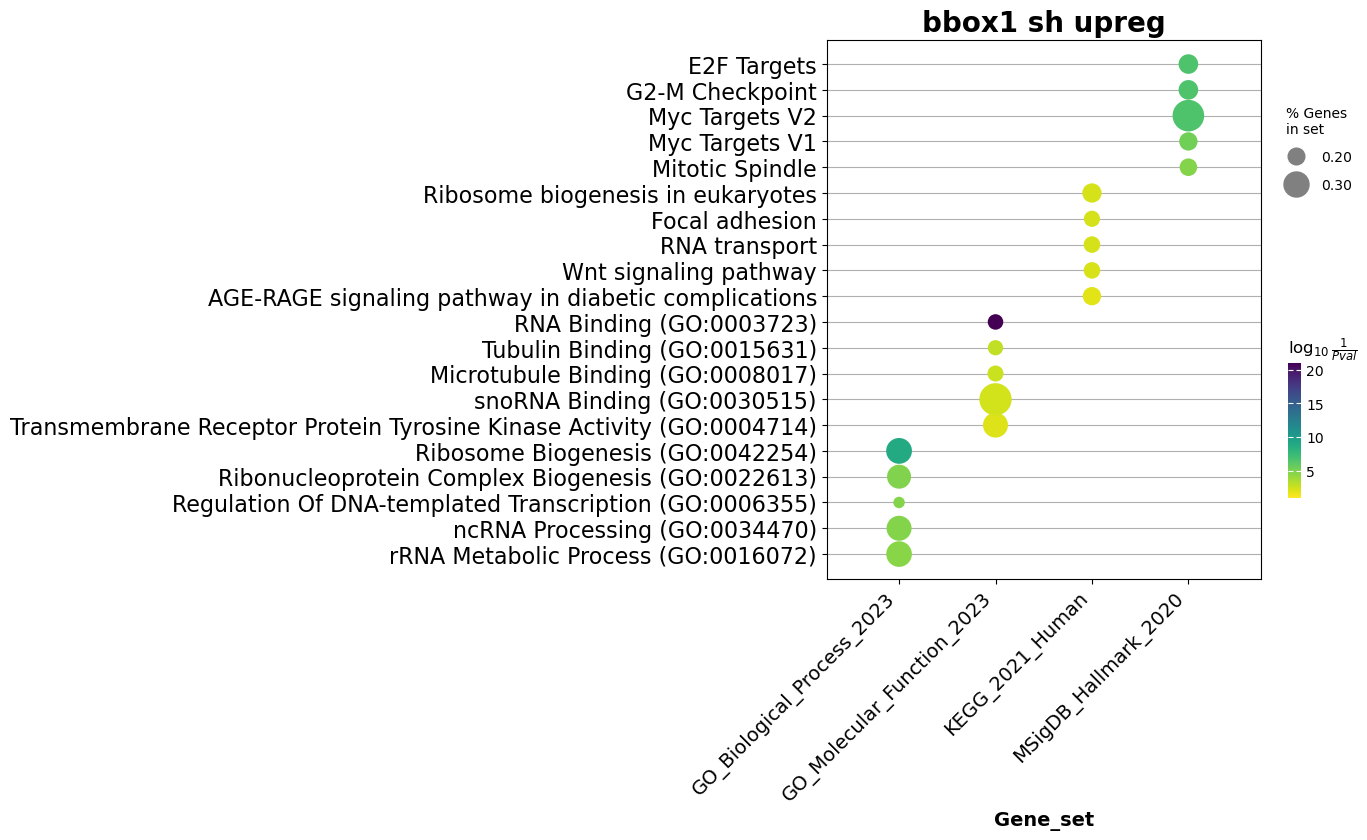

In [34]:
ax = dotplot(bbox1_selected_upreg_enr.results,
              column="Adjusted P-value",
              x='Gene_set',
              size=10,
              top_term=5,
              figsize=(7,7),
              title = "bbox1 sh upreg",
              xticklabels_rot=45,
              show_ring=False, 
              marker='o',
             )

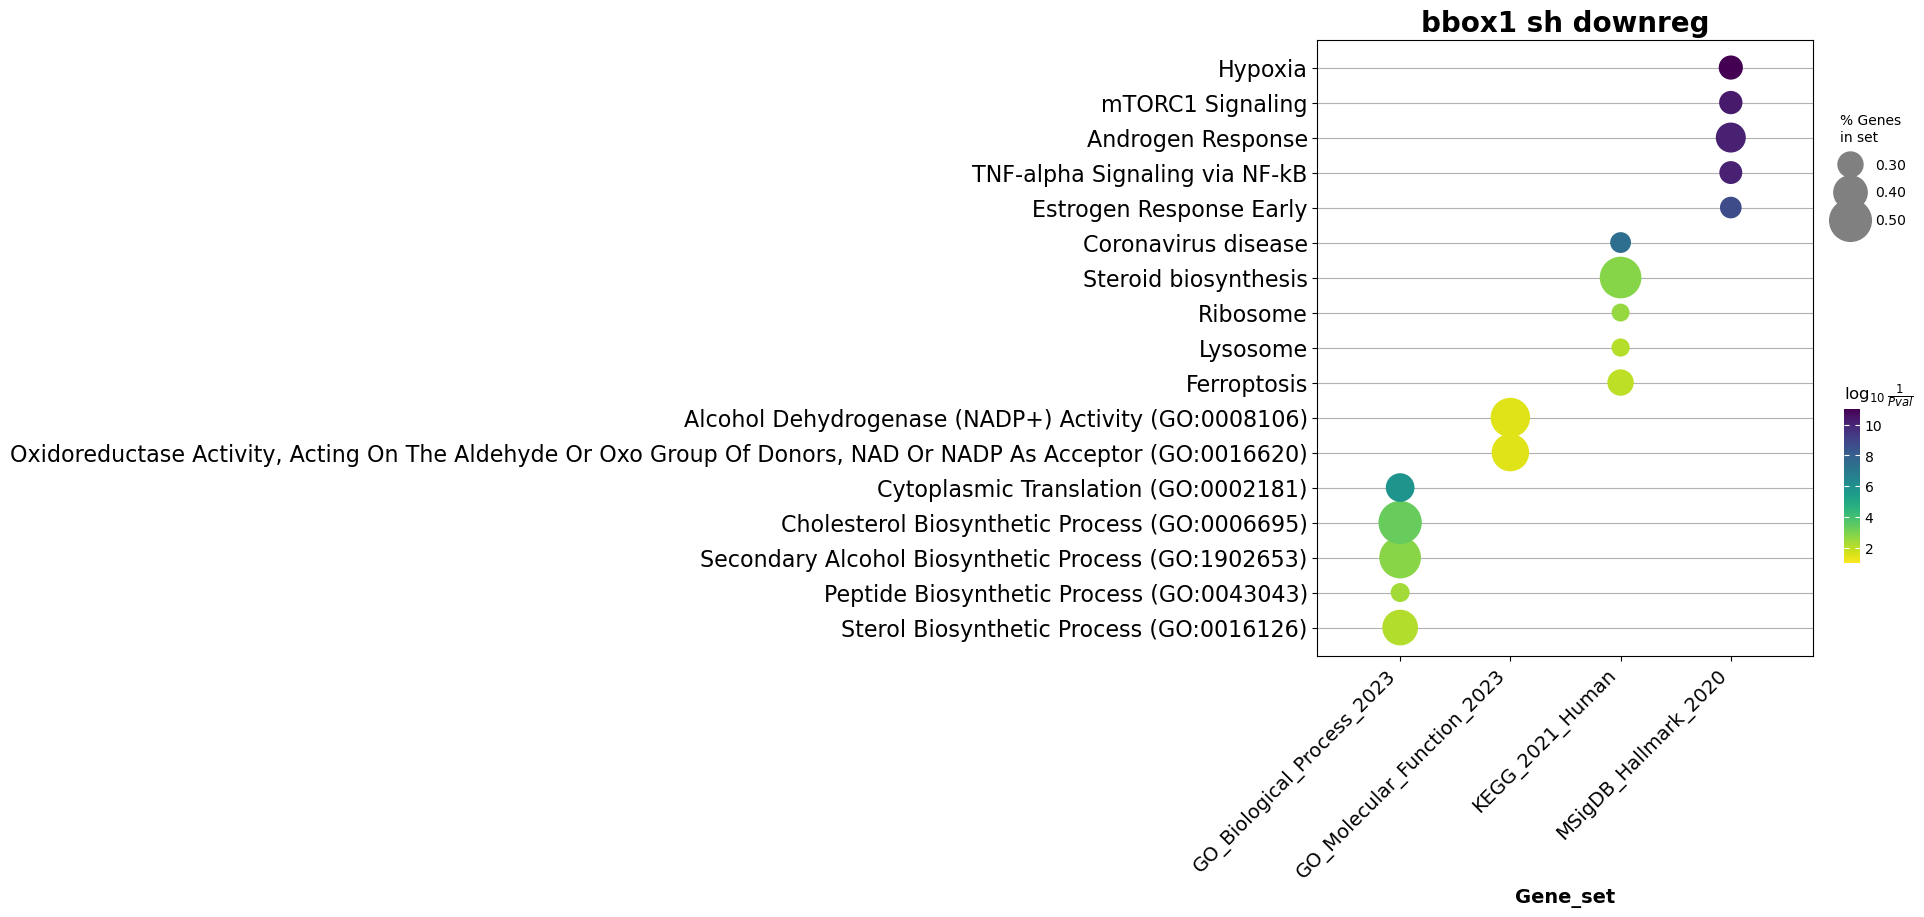

In [35]:
ax = dotplot(bbox1_selected_downreg_enr.results,
              column="Adjusted P-value",
              x='Gene_set', 
              size=10,
              top_term=5,
              figsize=(8,8),
              title = "bbox1 sh downreg",
              xticklabels_rot=45, 
              show_ring=False,
              marker='o',
             )

This study (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7642036/) explores the potential of BBOX1 as a new theraputic target for the treatment of Triple Negative Breast Cancer (TNBC). BBOX1 belongs to a family of 2-Oxoglutarate (2-OG) dependent enzymes that use oxygen and 2-OG as co-substrates to catalyze various cellular biological enzymatic reactions with a broad spectrum of substrates (e.g. DNA, RNA, and proteins).

In this study, BBOX1 was identified as potential target essential for cancer cell survival in TNBC cell lines using siRNA screens. Subsequently, BBOX1 was knocked down in these cells using 2 different BBOX1-specific shRNAs (sh1 and sh6) and bulk RNAseq analysis was performed to study the effects of absence of BBOX1 as compared to the control samples (non-specific shRNAs).

In this analysis, we study the enriched biological processes, molecular functions, biological pathways and biomolecular signatures of up and down-regulated genes in the treated samples (sh1 and sh6) v/s the control samples.

Enrichments in up-regulated genes: Looking at the enrichments from MsigDB Hallmark gene set, genes from MYC targets(V1 and V2),E2F targets and G2M-checkpoints seem to be significantly enriched in upregulated genes in sh1 and sh6 treated TNBC cell lines. Interestingly, all of these sub-gene sets are associated with cell proliferation. The strong enrichment from G2M-checkpoint genes in BBOX1 KD was also observed in the original study.  

Enrichments in down-regulated genes: Genes from Hypoxia, mTORC1 signalling seem to be enriched in down-regulated genes in TNBC cell lines treated with BBOX1 shRNAs. Since BBOX1 is indirectly involved in activating mTORC1-mediated glycolysis, down-regulation of mTORC1 signalling in BBOX1 KD cells is expected. Also, down-regulation of Hypoxia-related genes is expected since oxygen is one of the substrates used by BBOX1. 